In [19]:
from pytorch3d.datasets import ShapeNetCore
import os
from open3d import open3d as o3d
import numpy as np
import trimesh
import matplotlib.pyplot as plt

In [21]:
class ShapeNetVoxelizer:
    def __init__(self, resolution=32):
        self.resolution = resolution
        self.voxel_size = 1.0 / self.resolution

    def load_mesh(self, obj_path):
        """
        Load a mesh from an OBJ file, ensuring it is triangulated.
        Handles both single meshes and scenes with multiple meshes.
        """
        loaded = trimesh.load(obj_path)

        # If the loaded object is a Scene, process all geometries
        if isinstance(loaded, trimesh.Scene):
            # Attempt to convert the scene to a single mesh
            # This combines all geometries in the scene into one mesh
            mesh = trimesh.util.concatenate(tuple(loaded.geometry.values()))
        else:
            # If it's already a Trimesh object, use it directly
            mesh = loaded

        # Ensure the mesh is triangulated
        #if not mesh.is_empty and hasattr(mesh, 'faces'):
            #mesh = mesh.split()[0]  # Split into individual components and take the first, if necessary
            #mesh = mesh.triangulate()

        # Convert to Open3D mesh
        if not mesh.is_empty:
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.faces)
            o3d_mesh = o3d.geometry.TriangleMesh()
            o3d_mesh.vertices = o3d.utility.Vector3dVector(vertices)
            o3d_mesh.triangles = o3d.utility.Vector3iVector(faces)
            o3d_mesh.compute_vertex_normals()
        else:
            o3d_mesh = o3d.geometry.TriangleMesh()

        return o3d_mesh

    
    def normalize_mesh(self, mesh):
        """
        Normalize the mesh to fit within a unit cube centered at the origin.
        """
        aabb = mesh.get_axis_aligned_bounding_box()
        max_dim = max(aabb.get_extent())
        scale_factor = 1.0 / max_dim
        mesh.scale(scale_factor, center=aabb.get_center())
        mesh.translate(-mesh.get_center())
        #print(f"Vertices: {len(mesh.vertices)}, Faces: {len(mesh.triangles)}")
        return mesh

    def mesh_to_voxel_grid(self, mesh):
        """
        Convert a mesh to a voxel grid of the specified resolution.
        """
        voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(
            mesh,
            voxel_size=self.voxel_size
        )
        return voxel_grid

    def voxel_grid_to_array(self, voxel_grid):
        """
        Convert a voxel grid to a numpy array.
        """
        try:
            # Initialize an empty array for the voxel grid
            voxel_array = np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)

            # Assuming voxel_grid is correctly populated and aligned with the mesh
            for voxel in voxel_grid.get_voxels():
                # Calculate voxel indices based on the voxel grid's resolution and bounds
                index = voxel.grid_index
                if all(0 <= idx < self.resolution for idx in index):
                    voxel_array[index[0], index[1], index[2]] = 1

            return voxel_array
        except Exception as e:
            print(f"Error converting voxel grid to array: {e}")
            return np.zeros((self.resolution, self.resolution, self.resolution), dtype=np.uint8)


    def process_obj_file(self, obj_path):
        """
        Full processing pipeline for converting an OBJ file to a voxel grid array.
        """
        mesh = self.load_mesh(obj_path)
        normalized_mesh = self.normalize_mesh(mesh)
        voxel_grid = self.mesh_to_voxel_grid(normalized_mesh)
        voxel_array = self.voxel_grid_to_array(voxel_grid)
        return voxel_array


In [22]:
# Initialize ShapeNetCore dataset
SHAPENET_PATH = "D:/ShapeNet"
shapenet_dataset = ShapeNetCore(SHAPENET_PATH, version=2)

c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 207e69af994efa9330714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 2307b51ca7e4a03d30714334794526d4 under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 302612708e86efea62d2c237bfbc22ca under synset directory 02958343.
  warnings.warn(msg)
c:\Users\lmtop\anaconda3\envs\tdt4265\lib\site-packages\pytorch3d\datasets\shapenet\shapenet_core.py:127: UserWarning: Object file not found in the model directory 3c33f9f8edc558ce77aa0b62eed1492 under synset directory 02958343.
  warnings.warn(ms

In [23]:
print(len(shapenet_dataset))

52472


In [33]:
# Initialize the voxelizer
voxelizer = ShapeNetVoxelizer(resolution=32)

model = shapenet_dataset[50000]
obj_path = os.path.join(SHAPENET_PATH, model['synset_id'], model['model_id'], shapenet_dataset.model_dir)

voxel_array = voxelizer.process_obj_file(obj_path)

# Save the voxel array to a file
np.save("voxel_array.npy", voxel_array)
print(f"Voxel array shape: {voxel_array.shape}")



Vertices: 31711, Faces: 20609
Voxel array shape: (32, 32, 32)


In [58]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import affine_transform

# Convert voxel grid to point cloud
def voxel_grid_to_point_cloud(voxel_grid):
    points = np.argwhere(voxel_grid > 0)
    return points

# Perform PCA and align the voxel grid
def align_voxel_grid(voxel_grid):
    points = voxel_grid_to_point_cloud(voxel_grid)
    pca = PCA(n_components=3)
    pca.fit(points)
    rotation_matrix = pca.components_

    # Calculate the center of the voxel grid for rotation
    center = np.mean(points, axis=0)

    # Create affine transform matrix including the rotation and translation
    affine_matrix = np.eye(4)
    affine_matrix[:3, :3] = rotation_matrix
    affine_matrix[:3, 3] = center - center.dot(rotation_matrix)

    # Apply the affine transformation
    aligned_grid = affine_transform(voxel_grid, affine_matrix[:3, :3], offset=affine_matrix[:3, 3], order=1, mode='constant', cval=0)
    return aligned_grid

In [57]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.ndimage import affine_transform

def voxel_grid_to_point_cloud(voxel_grid):
    points = np.argwhere(voxel_grid > 0)
    return points

def align_voxel_grid(voxel_grid):
    points = voxel_grid_to_point_cloud(voxel_grid)
    pca = PCA(n_components=3)
    pca.fit(points)
    rotation_matrix = pca.components_

    # Calculate the geometric center of the original voxel grid
    original_center = np.mean(points, axis=0)

    # Calculate the new center after applying rotation
    rotated_center = original_center.dot(rotation_matrix.T)

    # Compute the offset needed to re-center the grid
    offset = original_center - rotated_center

    # Create affine transform matrix including the rotation and adjusted offset for centering
    affine_matrix = np.eye(4)
    affine_matrix[:3, :3] = rotation_matrix
    affine_matrix[:3, 3] = offset  # Apply the offset here

    # Apply the affine transformation with corrected offset
    aligned_grid = affine_transform(voxel_grid, affine_matrix[:3, :3], offset=affine_matrix[:3, 3], order=1, mode='constant', cval=0)
    return aligned_grid

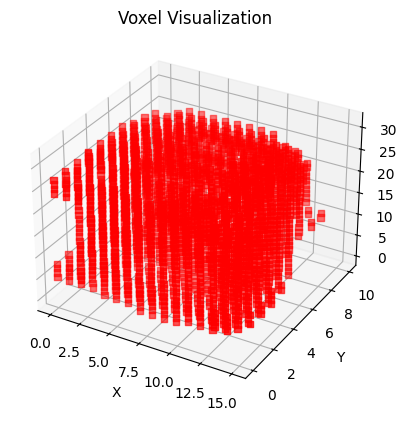

In [59]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the aligned voxel array
aligned_voxel_array = align_voxel_grid(voxel_array)

# Get the indices of the filled voxels

filled_indices = np.argwhere(voxel_array == 1)


# Plot the filled voxels as a 3D scatter plot
ax.scatter(filled_indices[:, 0], filled_indices[:, 1], filled_indices[:, 2], c='red', marker='s')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Voxel Visualization')

plt.show()

IndexError: index 0 is out of bounds for axis 1 with size 0

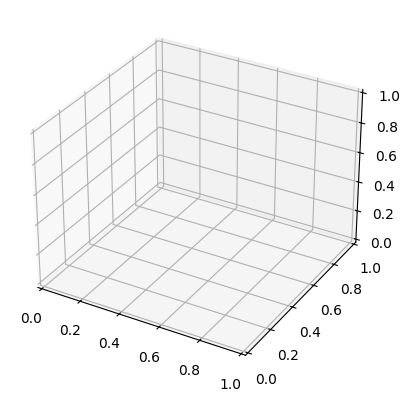

In [60]:
# Create a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Get the aligned voxel array
aligned_voxel_array = align_voxel_grid(voxel_array)

# Get the indices of the filled voxels

filled_indices = np.argwhere(aligned_voxel_array == 1)


# Plot the filled voxels as a 3D scatter plot
ax.scatter(filled_indices[:, 0], filled_indices[:, 1], filled_indices[:, 2], c='red', marker='s')

# Set plot labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Voxel Visualization')

plt.show()